In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.47:57060 Dashboard: http://10.148.0.47:8787/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GB


---


# 1. LLC results

In [5]:
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'

face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
#ds = xr.concat(D, dim='face')
#E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
#E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
#df=E.freq_time[1]-E.freq_time[0]
#f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
#f_cpd = f*86400/2./np.pi

In [5]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [6]:
E_dir_raw = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/raw/'
D = [xr.open_zarr(E_dir_raw+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
print(ds)
E_raw = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E_raw = E_raw.assign_coords(freq_cpd=E_raw.freq_time * 86400.) 
#print(E_raw)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1439, lat: 120)
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
Dimensions without coordinates: face
Data variables:
    A          (face, lat) float64 dask.array<shape=(13, 120), chunksize=(1, 120)>
    E          (face, lat, freq_time) float64 dask.array<shape=(13, 120, 1439), chunksize=(1, 60, 720)>


In [7]:
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)
df=E.freq_time[1]-E.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [8]:
E_llc_raw = (E_raw*df).sum(dim='freq_time')
E_llc_low = (E_raw*df - E.where((abs(E.freq_cpd)>0.5) , other=0.)*df*8/3).sum(dim='freq_time')
E_llc_high = (E.where((abs(E.freq_cpd)>0.5) , other=0.)*df*8/3).sum(dim='freq_time')
E_llc_semi = (E.where((abs(E.freq_cpd)>1.9) & (abs(E.freq_cpd)<2.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_llc_diurnal = (E.where((abs(E.freq_cpd)>0.9) & (abs(E.freq_cpd)<1.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_llc_f = (E.where(abs(E.freq_cpd+f_cpd)<.1, other=0.)*df*8/3).sum(dim='freq_time')#.where(abs(E.lat)>15)

In [9]:
E_llc_raw = np.real(E_llc_raw).rename('E_llc_raw')
E_llc_low = np.real(E_llc_low).rename('E_llc_low')
E_llc_high = np.real(E_llc_high).rename('E_llc_high')
E_llc_semi = np.real(E_llc_semi).rename('E_llc_semi')
E_llc_diurnal = np.real(E_llc_diurnal).rename('E_llc_diurnal')
E_llc_f = np.real(E_llc_f).rename('E_llc_f')
E_llc = xr.merge([E_llc_raw.to_dataset(), E_llc_low.to_dataset(), E_llc_high.to_dataset(), E_llc_semi.to_dataset(), E_llc_diurnal.to_dataset(), E_llc_f.to_dataset()])
%time E_llc.to_netcdf('/home1/datawork/xyu/LLC4320/E_llc_lat_mean.nc', mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


CPU times: user 2.34 s, sys: 180 ms, total: 2.52 s
Wall time: 12 s


Text(0.5,1,'LLC')

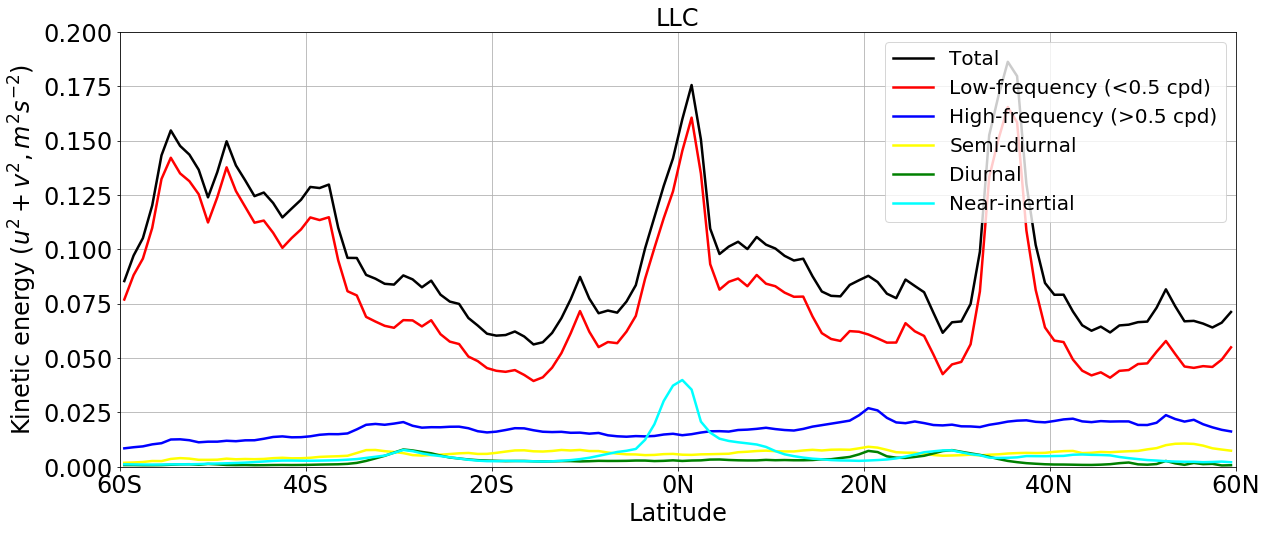

In [9]:
fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)', 'High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

E_llc_raw.plot(color='black', label=labels[0], linewidth=2.5) # total energy
E_llc_low.plot(color='red', label=labels[1], linewidth=2.5)
E_llc_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at high frequencies (< 2 days) 
E_llc_semi.plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
E_llc_diurnal.plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
E_llc_f.plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
#ax.set_yscale('log')
ax.set_ylim([0.,0.2])

# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC',fontsize=24)

_________
# 2. Drifter Results

In [9]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_raw = xr.open_zarr(data_dir+'E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window

In [10]:
df=ds_raw.freq_time[1]-ds_raw.freq_time[0]
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi

In [11]:
E_drifter_raw = (ds_raw.E_drifter_raw*df).sum(dim='freq_time')
E_drifter_low = (ds_raw.E_drifter_raw*df - (E_drifter.where((abs(E_drifter.freq_cpd)>0.5), other=0.))*df*8/3).sum(dim='freq_time')
E_drifter_high = (E_drifter.where((abs(E_drifter.freq_cpd)>0.5), other=0.)*df*8/3).sum(dim='freq_time')
E_drifter_semi = (E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_drifter_diurnal = (E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_drifter_f = (E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df*8/3).sum(dim='freq_time')#.where(abs(E_drifter.lat_bins)>15)

Text(0.5,1,'Drifters ')

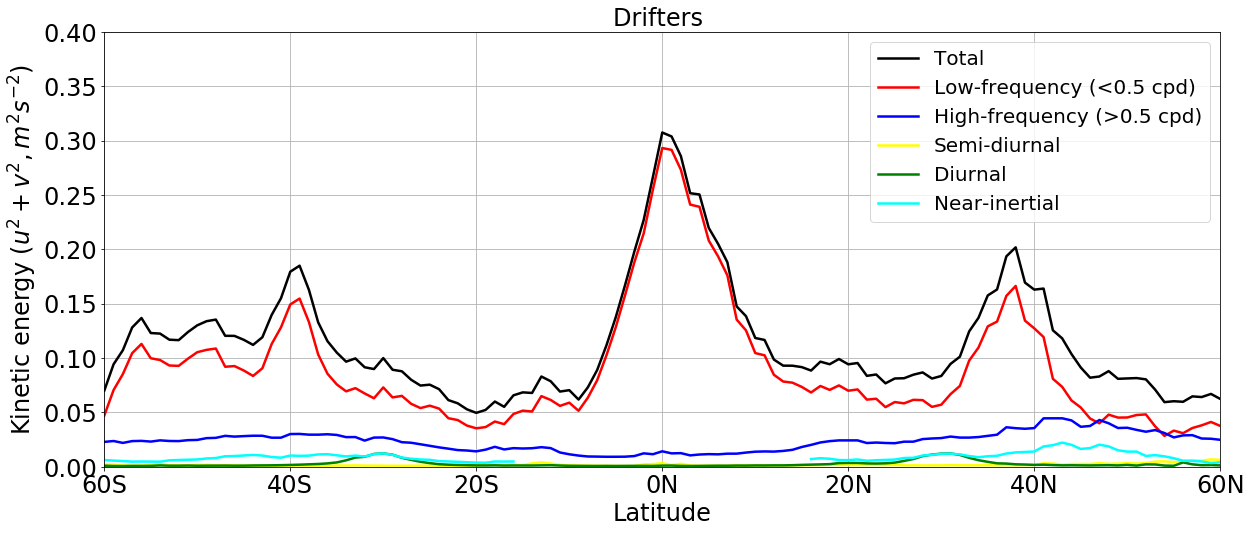

In [13]:
# compare each component by applying windowing

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

E_drifter_raw.plot(color='black', label=labels[0], linewidth=2.5) # total energy
E_drifter_low.plot(color='red', label=labels[1], linewidth=2.5) # total energy
E_drifter_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at low frequencies (> 5 day
E_drifter_semi.plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
E_drifter_diurnal.plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
E_drifter_f.where(abs(E_drifter.lat_bins)>15).plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
#ax.set_yscale('log')
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters ',fontsize=24)

______
# 3. Direct comparison

Text(0.5,1,'Diurnal KE')

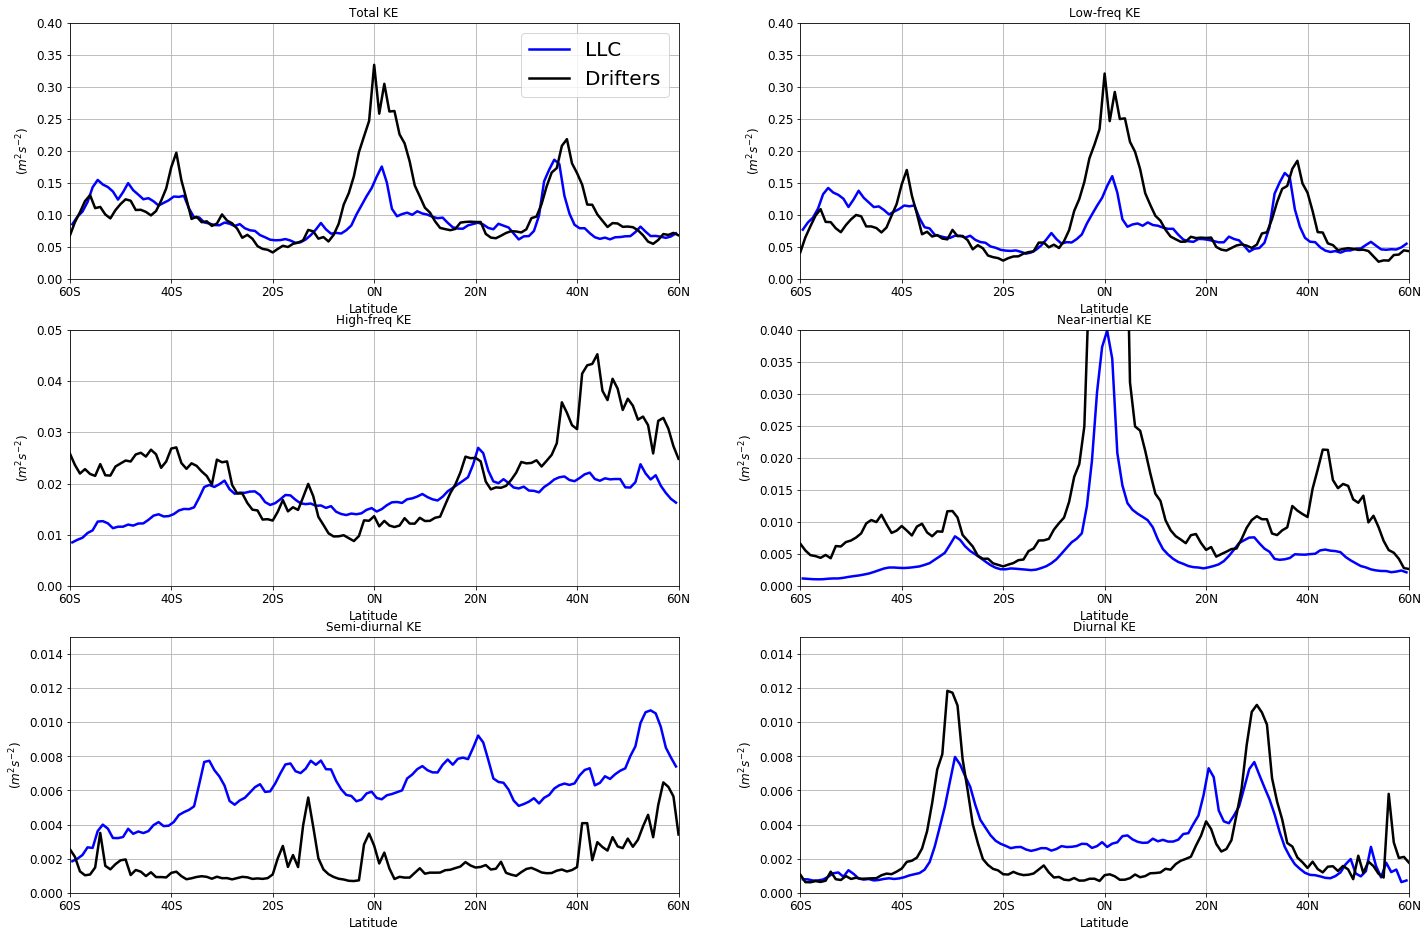

In [17]:
fig= plt.subplots(figsize=(24,16))

labels = ['LLC', 'Drifters']
fron_size = 12

ax=plt.subplot(321)
E_llc_raw.plot(color='blue', label=labels[0], linewidth=2.5)   # energy at low frequencies (> 5 days) 
E_drifter_raw.plot(color='black', label=labels[1], linewidth=2.5)   # energy at low frequencies (> 5 days) 
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Total KE',fontsize=fron_size)


ax=plt.subplot(322)
E_llc_low.plot(color='blue', label=labels[0],  linewidth=2.5) # energy around semi-diurnal frequencies
E_drifter_low.plot(color='black', label=labels[1],  linewidth=2.5) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': 32}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Low-freq KE',fontsize=fron_size)


ax=plt.subplot(323)
E_llc_high.plot(color='blue', linewidth=2.5) # energy around diurnal frequencies
E_drifter_high.plot(color='black', linewidth=2.5) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.05])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('High-freq KE',fontsize=fron_size)


ax=plt.subplot(324)
E_llc_f.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_f.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.04])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Near-inertial KE',fontsize=fron_size)


ax=plt.subplot(325)
E_llc_semi.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_semi.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.015])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Semi-diurnal KE',fontsize=fron_size)

ax=plt.subplot(326)
E_llc_diurnal.plot(color='blue', label=labels[0], linewidth=2.5) # energy around f
E_drifter_diurnal.plot(color='black', label=labels[1], linewidth=2.5) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.015])
# Label, size
ax.set_xlabel('Latitude',fontsize=fron_size)
ax.tick_params(labelsize=fron_size)
ax.set_ylabel('($m^2 s^{-2}$)',fontsize=fron_size)
ax.set_title('Diurnal KE',fontsize=fron_size)
#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_eachcomponent_comparison_normal.png')

Text(0.5,1,'LLC4320')

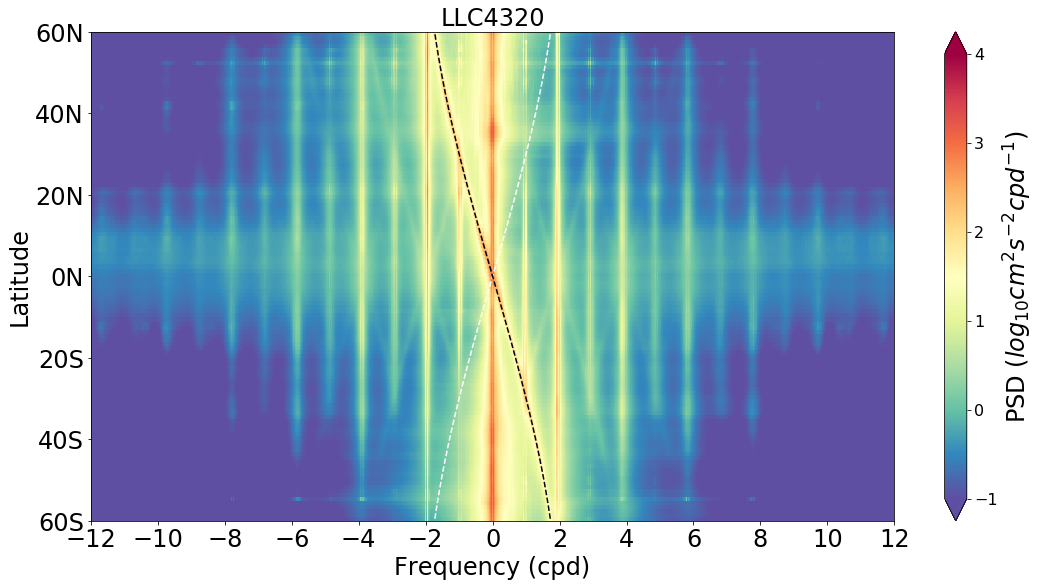

In [15]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')
ax.set_title('LLC4320',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_lat_LLC.png')


Text(0.5,1,'Drifter')

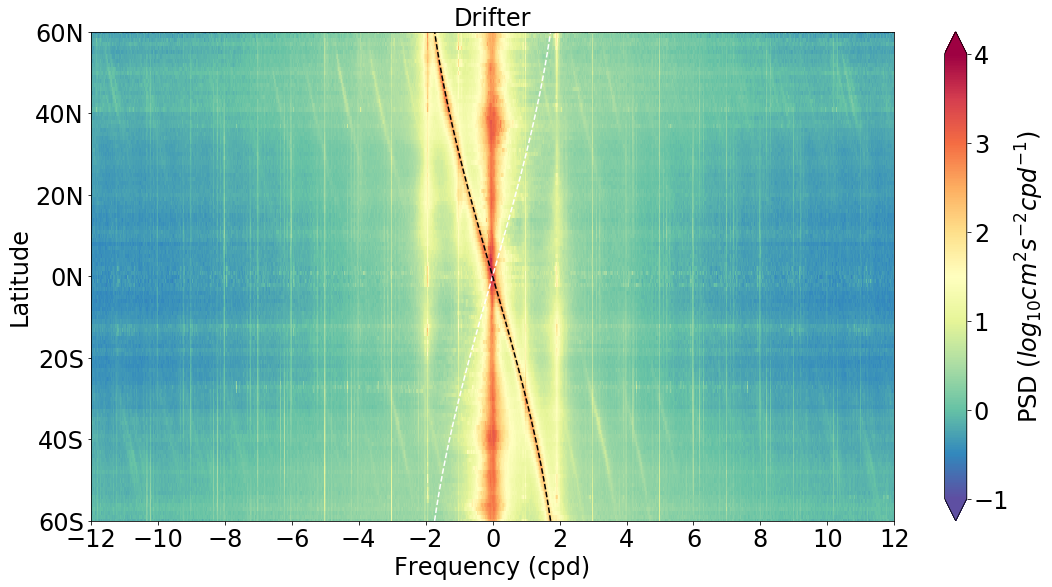

In [17]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifter',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_lat_Drifter.png')


# global mean

In [19]:
llc_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
ds_llc_cycl = xr.open_zarr(llc_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(llc_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

In [20]:
drifter_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(drifter_dir+'E_drifter_globalmean.zarr')
print(ds)
E_drifter_anti = ds.E_drifter_anti
E_drifter_cycl = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


Text(0.5,1,'LLC4320 vs. Drifter')

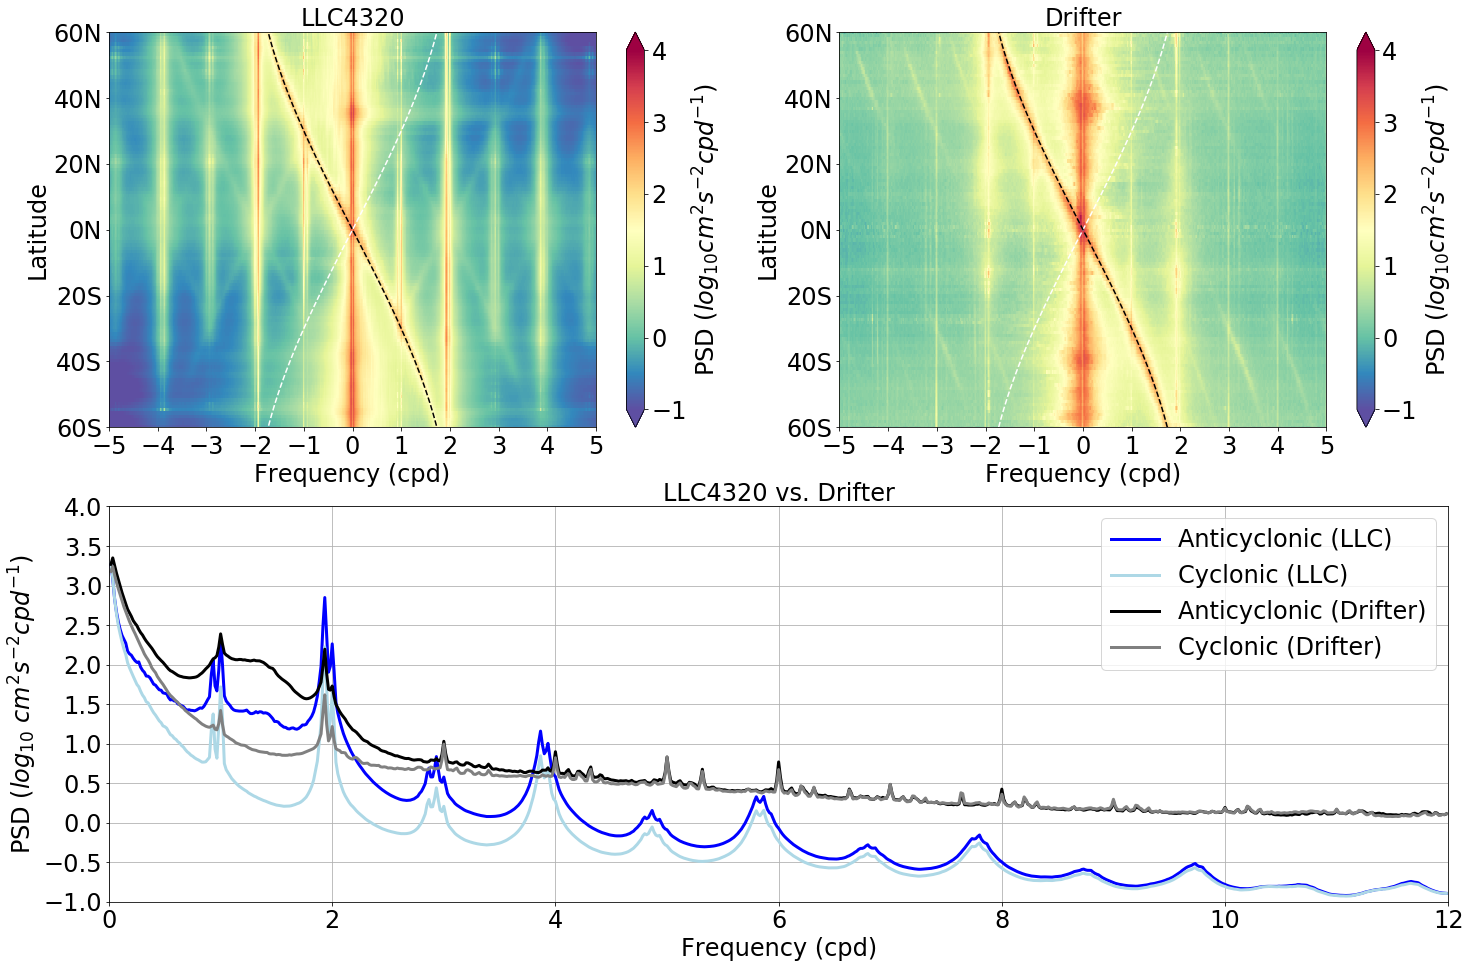

In [19]:
font_size = 24

fig, ax = plt.subplots(figsize=(24,16))


ax = plt.subplot(2,2,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')
ax.set_title('LLC4320',fontsize=font_size)


ax = plt.subplot(2,2,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifter',fontsize=font_size)


ax = plt.subplot(2,2,(3,4))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,4])
ax.set_yticks([-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])

#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 vs. Drifter',fontsize=font_size)


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison.png')

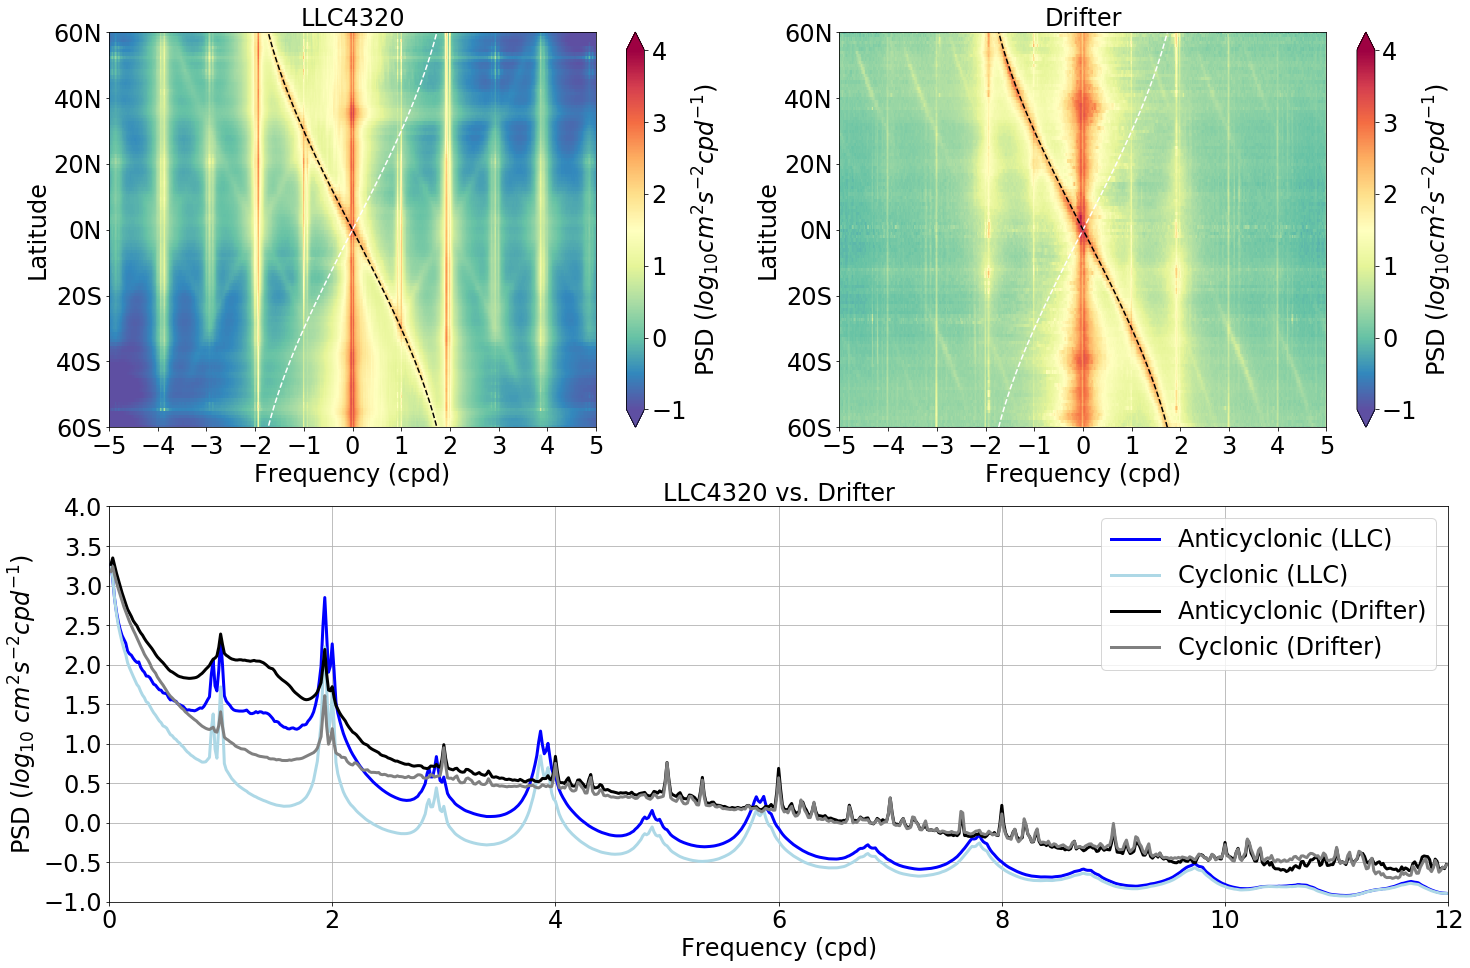

In [21]:
font_size = 24

fig, ax = plt.subplots(figsize=(24,16))


ax = plt.subplot(2,2,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')
ax.set_title('LLC4320',fontsize=font_size)


ax = plt.subplot(2,2,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifter',fontsize=font_size)


ax = plt.subplot(2,2,(3,4))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti-1.).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl-1.).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,4])
ax.set_yticks([-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])

#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 vs. Drifter',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison.png')


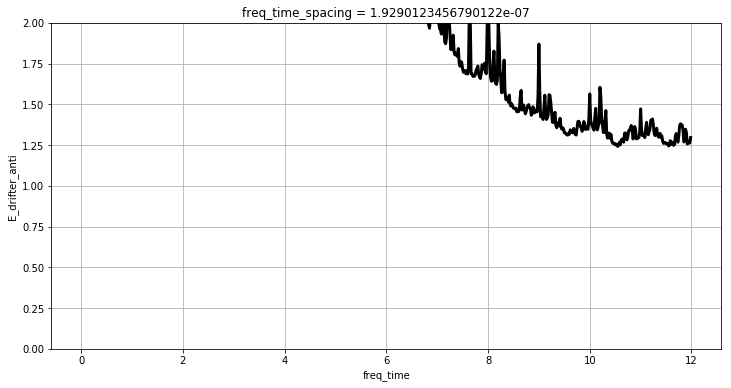

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
E_drifter_anti.plot(linewidth=3, color='black')
ax.set_ylim([0.,2])
ax.grid()

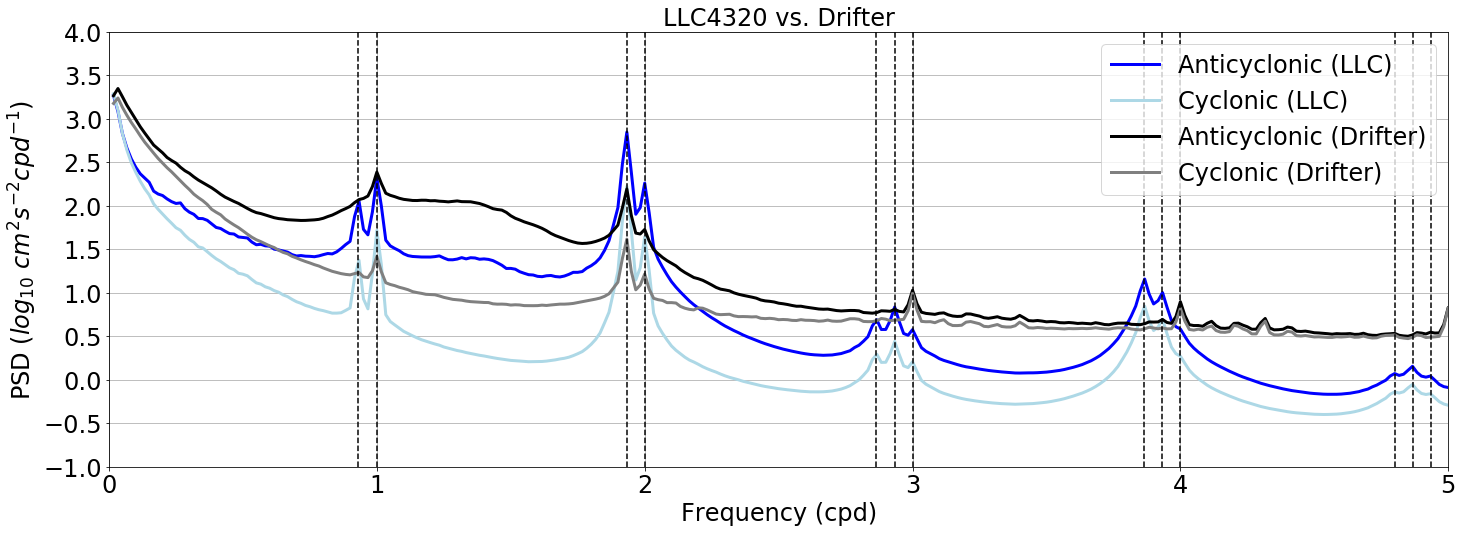

In [18]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.,4])
ax.set_yticks([-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,5.])
#ax.set_xticks([0., 1., 2., 3., 4., 5.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. Drifter',fontsize=24)



# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[-1,1e6],'k--') # O1
ax.plot([1,1],[-1,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[-1,1e6],'k--') # M2
ax.plot([2,2],[-1,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[-1,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[-1,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[-1,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[-1,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[-1,1e6],'k--') # MS4
ax.plot([4,4],[-1,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[-1,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[-1,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[-1,1e6],'k--') # MSK5


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison_1_5.png')

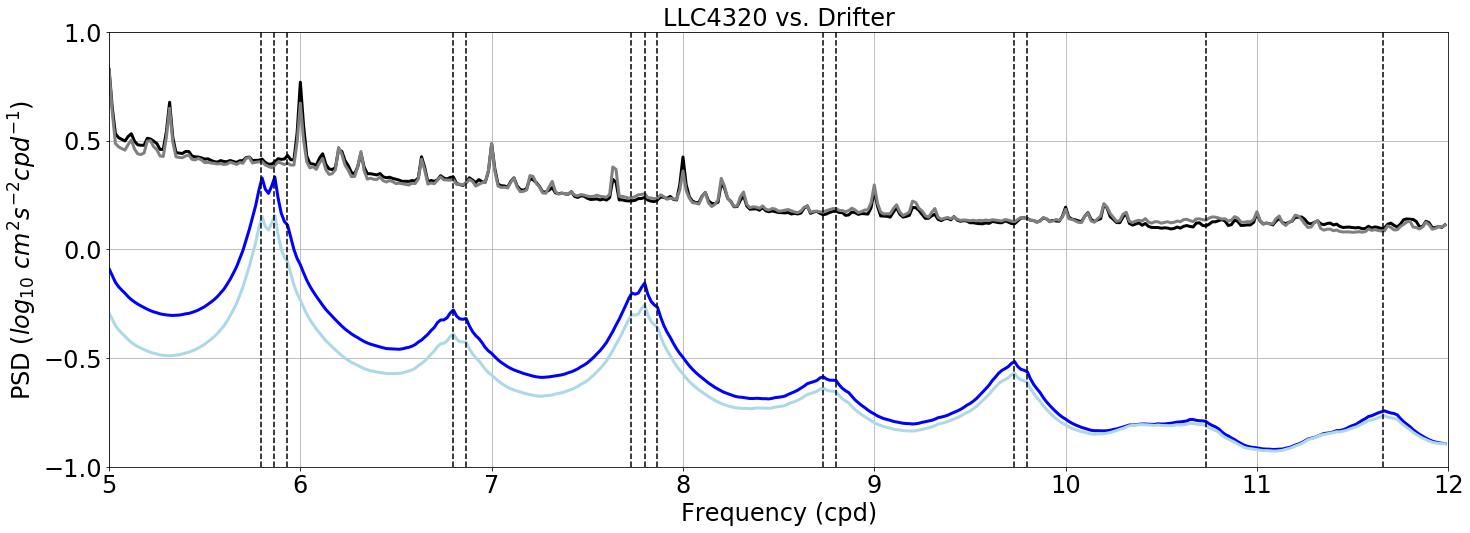

In [19]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

#ax.legend(); 
ax.grid()
ax.set_ylim([-1.,1])
ax.set_yticks([-1.,-0.5, 0., 0.5, 1.])
ax.set_xlim([5.,12.])
#ax.set_xticks([5., 6., 7., 8., 9., 10., 11., 12.])
#ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. Drifter',fontsize=24)



# 5
ax.plot([4.79956,4.79956],[-1,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[-1,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[-1,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[-1,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[-1,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[-1,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[-1,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[-1,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[-1,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[-1,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[-1,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[-1,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[-1,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[-1,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[-1,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[-1,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[-1,1e6],'k--') # ST34


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison_5_12.png')

In [23]:
cluster.scheduler.close()

<Future finished result=None>